# Explore Chinook Database Using SQL

We'll use the Chinook database which is provided as a SQLite database file called chinook.db. A copy of the database schema is below .We will answer the following questions.

https://s3.amazonaws.com/dq-content/191/chinook-schema.svg

# Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline

db='chinook.db'

In [2]:
#Create a run_query() function,that takes a SQL query as an argument and returns a pandas dataframe of that query
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)  
    
#Create a run_command() function that takes a SQL command as an argument and executes it using the sqlite module.
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level=None
        conn.execute(c)
        
#Create a show_tables() function that calls the run_query() function to return a list of all tables and views in the database.
def show_tables():
    q='''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)
    
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase


The Chinook record store has just signed a deal with a new record label,The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [3]:
q1='''
with genre_sum as
(
SELECT
    g.name genre_name,
    SUM(il.quantity) tracks_sold
FROM genre g 
INNER JOIN track t ON g.genre_id=t.genre_id
INNER JOIN invoice_line il ON t.track_id=il.track_id
INNER JOIN invoice i ON i.invoice_ID=il.invoice_id
INNER JOIN customer c ON i.customer_id=c.customer_id
WHERE c.country="USA"
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
)
SELECT
    genre_name,
    tracks_sold,
    CAST(tracks_sold AS FLOAT)/(SELECT SUM(tracks_sold) FROM genre_sum) percentage
FROM genre_sum
'''

run_query(q1)

,genre_name,tracks_sold,percentage
0,Rock,561,0.551622
1,Alternative & Punk,130,0.127827
2,Metal,124,0.121927
3,R&B/Soul,53,0.052114
4,Blues,36,0.035398
5,Alternative,35,0.034415
6,Latin,22,0.021632
7,Pop,22,0.021632
8,Hip Hop/Rap,20,0.019666
9,Jazz,14,0.013766


<function matplotlib.pyplot.show>

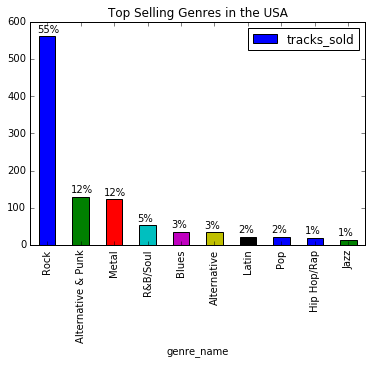

In [4]:
#Create a plot to show this data.
genre_sales_usa=run_query(q1)
genre_sales_usa.plot.bar(x="genre_name",y="tracks_sold",title='Top Selling Genres in the USA')

for i,label in enumerate(list(genre_sales_usa.index)):
    score=genre_sales_usa.loc[label,"tracks_sold"]
    label=(genre_sales_usa.loc[label,"percentage"]*100).astype(int).astype(str)+"%"
    plt.annotate(str(label),(i-0.3,score+10))
plt.show

So we can find that the best sale genre is rock with more than half percentages.

# Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We will analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [5]:
#Write a query that finds the total dollar amount of sales assigned to each sales 
q2='''
SELECT 
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    (SELECT SUM(i.total) FROM invoice ) total_sales
FROM employee e 
INNER JOIN customer c ON c.support_rep_id=e.employee_id
INNER JOIN invoice i ON i.customer_id=c.customer_id
GROUP BY 1
'''

run_query(q2)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


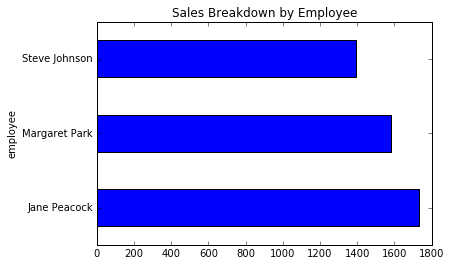

In [6]:
#Create a plot of the results of your query
total_sales=run_query(q2)
total_sales.set_index("employee",inplace=True)
total_sales.plot.barh(legend=False,title='Sales Breakdown by Employee')

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

# Analyzing Sales by Country

Next we will analyze the sales data for customers from each different country.In particular, you have been directed to calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer
average order value

In [7]:
sales_by_country='''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
SELECT 
    country,
    total_customer,
    total_sales,
    customer_lifetime_value,
    average_order
FROM
(SELECT 
    country,
    count(distinct customer_id) total_customer,
    SUM(unit_price) total_sales,
    SUM(unit_price)/count(distinct customer_id) customer_lifetime_value,
    SUM(unit_price) / count(distinct invoice_id) average_order,
    CASE
        WHEN country='Other' then 1
        ELSE 0
    END AS sort
FROM country_or_other
GROUP BY 1
ORDER BY sort,2 DESC 
)    
'''

run_query(sales_by_country)

,country,total_customer,total_sales,customer_lifetime_value,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,United Kingdom,3,245.52,81.840000,8.768571
6,Czech Republic,2,273.24,136.620000,9.108000
7,India,2,183.15,91.575000,8.721429
8,Portugal,2,185.13,92.565000,6.383793
9,Other,15,1094.94,72.996000,7.448571


As we can see that USA has most customer numbers of 13 with highest total sales (1040.49).But for average order values,Czech Republic got the champion,with 136.62.

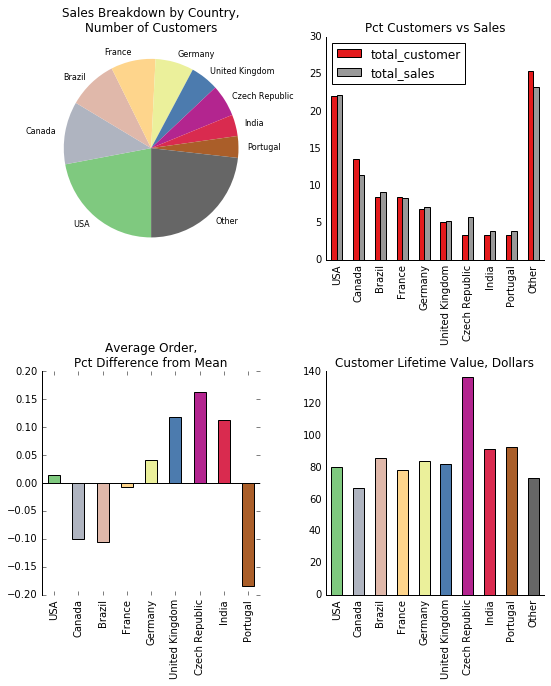

In [8]:
#create a visualization
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

#top right
cvd_cols = ["total_customer","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c]/=custs_vs_dollars[c].sum()/100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales")
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = (avg_order-avg_order.mean())/avg_order.mean()
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean",
)
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

#bottom left
customer_lifetime_value= country_metrics["customer_lifetime_value"].copy()
customer_lifetime_value.index.name = ''
customer_lifetime_value.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars")

ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

* Czech Republic
* United Kingdom
* India

# Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [18]:
q4='''
WITH ilt AS
    (SELECT 
        il.invoice_id invoice_id,
        MIN(il.track_id) first_track_id
    FROM invoice_line il 
    GROUP BY 1
    )
    
SELECT
    sort,
    count(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT)/(SELECT count(*) FROM invoice) percent
    
FROM
(
SELECT
    ilt.*,
    CASE WHEN    
    (SELECT t.track_id FROM track t where t.album_id = 
        (SELECT t2.album_id from track t2 where t2.track_id=ilt.first_track_id)
        EXCEPT
        SELECT il2.track_id FROM invoice_line il2 where il2.invoice_id=ilt.invoice_id
        )
        AND
        (
        SELECT il2.track_id FROM invoice_line il2 where il2.invoice_id=ilt.invoice_id
        EXCEPT
        SELECT t.track_id FROM track t where t.album_id = 
        (SELECT t2.album_id from track t2 where t2.track_id=ilt.first_track_id)
    )
        IS NULL THEN "yes"
        ELSE "no"
    END AS "sort"
    FROM ilt
)
GROUP BY sort
    
'''
run_query(q4)

,sort,number_of_invoices,percent
0,no,557,0.907166
1,yes,57,0.092834


Album purchases account for 9.28% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one tenth of revenue.